In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from __future__ import division

Some examples and notes on getting started in Theano, loosely following the official [tutorial](http://deeplearning.net/tutorial/).

In [3]:
import theano
import theano.tensor as T
from theano import function

In [4]:
x = T.dscalar('x')
y = T.dscalar('y')
z = x + y
f = function([x, y], z)

In [5]:
f(2,3)

array(5.0)

In [6]:
type(x)

theano.tensor.var.TensorVariable

In [7]:
x.type

TensorType(float64, scalar)

In [8]:
from theano import pp

In [9]:
pp(z)

'(x + y)'

In [10]:
x = T.dmatrix('x')
y = T.dmatrix('y')
z = x + y
f = function([x, y], z)

In [11]:
import numpy as np

In [12]:
f(np.array([[1,2],[3,4]]), np.array([[1,2],[3,4]]))

array([[ 2.,  4.],
       [ 6.,  8.]])

### Logistic function

In [13]:
x = T.dmatrix('x')
s = 1 / (1 + T.exp(-x))
logistic = function([x], s)
logistic([[0, 1], [-1, -2]])

array([[ 0.5       ,  0.73105858],
       [ 0.26894142,  0.11920292]])

### Default arguments

In [14]:
from theano import Param

In [15]:
x, y = T.dscalars('x', 'y')
z = x + y
f = function([x, Param(y, default=1)], z)

In [16]:
f(33)

array(34.0)

### Shared variables

In [17]:
from theano import shared

In [18]:
state = shared(0)
inc = T.iscalar('inc')
accumulator = function([inc], state, updates=[(state, state+inc)])

In [19]:
state.set_value(0)

In [20]:
accumulator(1)

array(0)

In [21]:
decrementor = function([inc], state, updates=[(state, state-inc)])

In [22]:
decrementor(1)

array(1)

In [23]:
# demonstrate use of `givens`
identity = function([inc], state, givens=[(state, inc)])

In [24]:
identity(5)

array(5, dtype=int32)

In [25]:
add1 = function([], state, updates=[(state, state+1)])

In [26]:
add1()

array(0)

### Random numbers

In [27]:
from theano.tensor.shared_randomstreams import RandomStreams

In [28]:
srng = RandomStreams(seed=123)
rv_u = srng.uniform((2,2))
rv_n = srng.normal((2,2))
f = function([], rv_u)
g = function([], rv_n, no_default_updates=True)
nearly_zeros = function([], rv_u + rv_u - 2 * rv_u)

In [29]:
f()

array([[ 0.72803009,  0.59044123],
       [ 0.23715077,  0.69958932]])

In [30]:
nearly_zeros()

array([[ 0.,  0.],
       [ 0.,  0.]])

### Monte Carlo $\pi$ estimation

In [31]:
m = 100000 # number of trials
rv_u = srng.uniform((m,))
r2 = rv_u**2 + rv_u**2
pi_est = function([], 4*T.mean(r2 < 1))

In [32]:
pi_est()

array(2.82804)

Would expect the above to work from the tutorial. Instead, seem to need:

In [33]:
m = 1000000 # number of trials
rv_u1 = srng.uniform((m,))
rv_u2 = srng.uniform((m,))
r2 = rv_u1**2 + rv_u2**2
pi_est = function([], 4*T.mean(r2 < 1))

In [34]:
pi_est()

array(3.1452199999999997)

### Logistic regression

In [35]:
from sklearn.datasets import *
from sklearn.cross_validation import train_test_split

In [36]:
data = load_iris()
Xtrain, Xtest, ytrain, ytest = (
    train_test_split(data['data'], np.where(data['target'] == 0, 0, 1)))

In [37]:
n, d = Xtrain.shape

In [38]:
alpha = 1e-3 # learning rate
lmbd = 0.05  # regularization

In [39]:
X = T.matrix('X')
y = T.vector('y')
w = shared(np.random.randn(d), name='w')
b = shared(0., name='b')

p = 1 / (1 + T.exp(-T.dot(X, w) - b))
pred = p > 0.5
xent = -y * T.log(p) - (1-y) * T.log(1-p) # cross-entropy loss
cost = xent.mean() + lmbd * (w**2).sum()
gw, gb = T.grad(cost, [w, b])

train = function(inputs=[X, y],
                 outputs=[pred, xent],
                 updates=[(w, w - alpha*gw), 
                          (b, b - alpha*gb)])

predict = function(inputs=[X], outputs=pred)

In [40]:
training_steps = 100

for i in range(training_steps):
    pred, err = train(Xtrain, ytrain)
    
(predict(Xtest) == ytest).mean()

0.28947368421052633

### Multi-class (softmax) logistic regression

Generalized logisitic regression with hypothesis

$$
h_{\Theta}(x) 
= \left( \sum_{i=1}^k e^{\theta_i^T x} \right)^{-1}
\begin{bmatrix}
e^{\theta_1^T x} \\
e^{\theta_2^T x} \\
\vdots \\
e^{\theta_k^T x}
\end{bmatrix}
= \mathrm{softmax} (\Theta^{T} x)
$$

In [41]:
u = T.dvector('u')
f = function([u], T.nnet.softmax(u))

In [42]:
a = np.array([1.,2,4])
f(a)

array([[ 0.04201007,  0.1141952 ,  0.84379473]])

In [43]:
a/a.sum()

array([ 0.14285714,  0.28571429,  0.57142857])

In [44]:
from numpy.random import randn

In [45]:
# turn off optimizer for more helpful debug info
from theano import config
config.optimizer = 'None'
config.exception_verbosity = 'high'

In [46]:
class LogisticRegression:
    
    def __init__(self, lrate=1e-3, n_iter=1000):
        self.lrate = lrate
        self.n_iter = n_iter
        
    def fit(self, Xd, yd, k):
        X = T.dmatrix('X')
        y = T.ivector('y')
        N, d = Xd.shape
        
        self.W = shared(randn(d, k), 'W') # weights
        self.b = shared(0., 'b') # bias
        
        # N x k matrix of hypotheses
        self.H = T.nnet.softmax(T.dot(X, self.W) + self.b)
        
        # N x 1 vector of predictions (predict class w/ highest prob.)
        y_pred = T.argmax(self.H, axis=1)
        
        # cost function (log-likelihood loss)
        cost = -T.mean(T.log(self.H)[T.arange(y.shape[0]), y])
        
        # gradient of cost function
        gW, gb = T.grad(cost, [self.W, self.b])
        
        # gradient descent updates
        updates = [(self.W, self.W - self.lrate*gW),
                   (self.b, self.b - self.lrate*gb)]
        
        self.train = function(
            inputs=[X, y],
            outputs=cost,
            updates=updates,
            allow_input_downcast=True)
        
        self.predict_proba = function(
            inputs=[X],
            outputs=self.H,
            allow_input_downcast=True)

        self.predict = function(
            inputs=[X], 
            outputs=y_pred,
            allow_input_downcast=True)
        
        for i in range(self.n_iter):
            self.train(Xd, yd)

Test on digit classification.

In [47]:
data = load_digits()

In [48]:
Xtrain, Xtest, ytrain, ytest = (
    train_test_split(data['data'], data['target']))

In [49]:
Xtrain.shape

(1347, 64)

In [50]:
ytrain.shape

(1347,)

In [51]:
clf = LogisticRegression(lrate=0.01, n_iter=1000)
clf.fit(Xtrain, ytrain, 10)
(clf.predict(Xtest) == ytest).mean()

0.9044444444444445

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


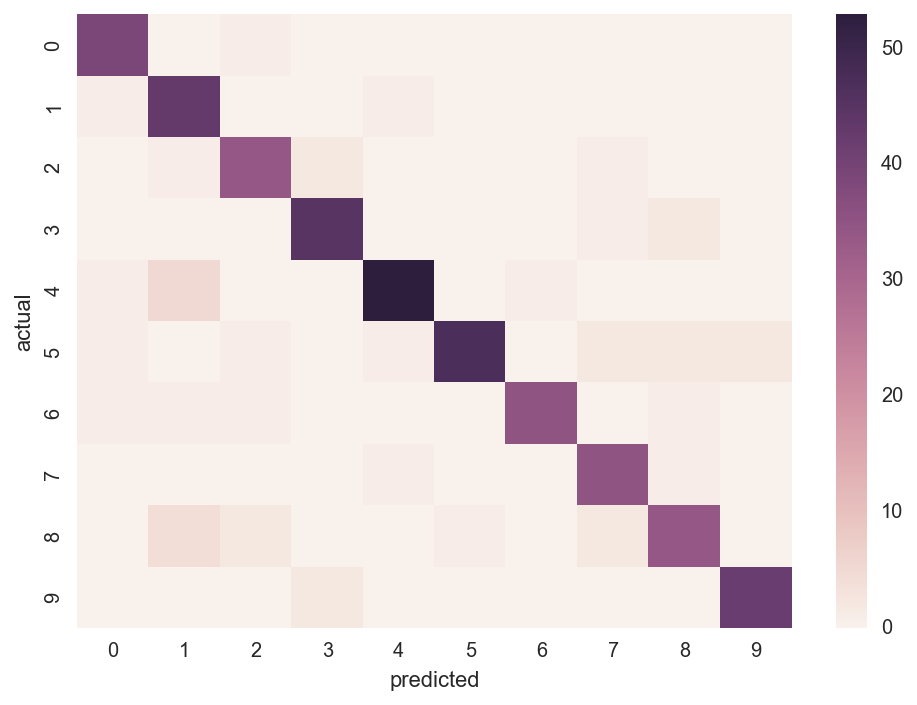

In [53]:
sns.heatmap(confusion_matrix(ytest, clf.predict(Xtest)))
plt.xlabel('predicted')
plt.ylabel('actual');

### Single hidden layer

3-layer (input, hidden, output) network with complete connectivity between layers. Example from Andrew Ng's ML course on Coursera.

\begin{align*}
a^{(1)} &= x \\
z^{(2)} = \Theta^{(1)} a^{(1)} \quad
a^{(2)} &= g(z^{(2)}) \\
z^{(3)} = \Theta^{(2)} a^{(2)} \quad
a^{(3)} &= g(z^{(3)}) = h_{\theta}(x)
\end{align*}


In [54]:
from sklearn.preprocessing import OneHotEncoder

data = load_digits()

X, y = data['data'], data['target']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
ytrain = OneHotEncoder(sparse=False).fit_transform(ytrain.reshape(-1,1))

In [55]:
N, d = Xtrain.shape
h = 25 # number of hidden units
k = ytrain.shape[1] # number of classes
alpha = 0.01 # regularization coefficient
lrate = 0.1 # learning rate
sigma = 0.1 # spread of random initial weights

In [56]:
X = T.dmatrix('X')
Y = T.imatrix('y')

# randomly initialize biases and weights
b1 = shared(sigma*randn(), 'b1')
b2 = shared(sigma*randn(), 'b2')
Theta1 = shared(sigma*randn(d, h), 'Theta1')
Theta2 = shared(sigma*randn(h, k), 'Theta2')

params = [Theta1, b1, Theta2, b2]

g = lambda z: 1/(1 + T.exp(-z)) #  logistic activation function

A1 = X
A2 = g(T.dot(A1, Theta1) + b1) # (N, d) x (d, h) -> (N, h)
A3 = g(T.dot(A2, Theta2) + b2) # (N, h) x (h, k) -> (N, k)
H = A3

# L2 regularization penalty
L2reg = (Theta1**2).sum() + (Theta2**2).sum()

cost = -T.mean(Y*T.log(H) + (1-Y)*T.log(1-H)) + alpha*L2reg

gradients = T.grad(cost, params)
updates = [(p, p - lrate*gp) for p, gp in zip(params, gradients)]

train = function([X, Y], cost, 
                 updates=updates,
                 allow_input_downcast=True)

y_pred = T.argmax(H, axis=1)
predict = function([X], y_pred, allow_input_downcast=True)

In [57]:
for i in range(1000):
    cost = train(Xtrain, ytrain)
    if i % 100 == 0:
        print cost

0.867399776223
0.446501110257
0.398836178706
0.367673632822
0.346744515289
0.33243270078
0.322231508237
0.315004257515
0.309751702433
0.305872656974


In [58]:
(predict(Xtest) == ytest).mean()

0.80666666666666664

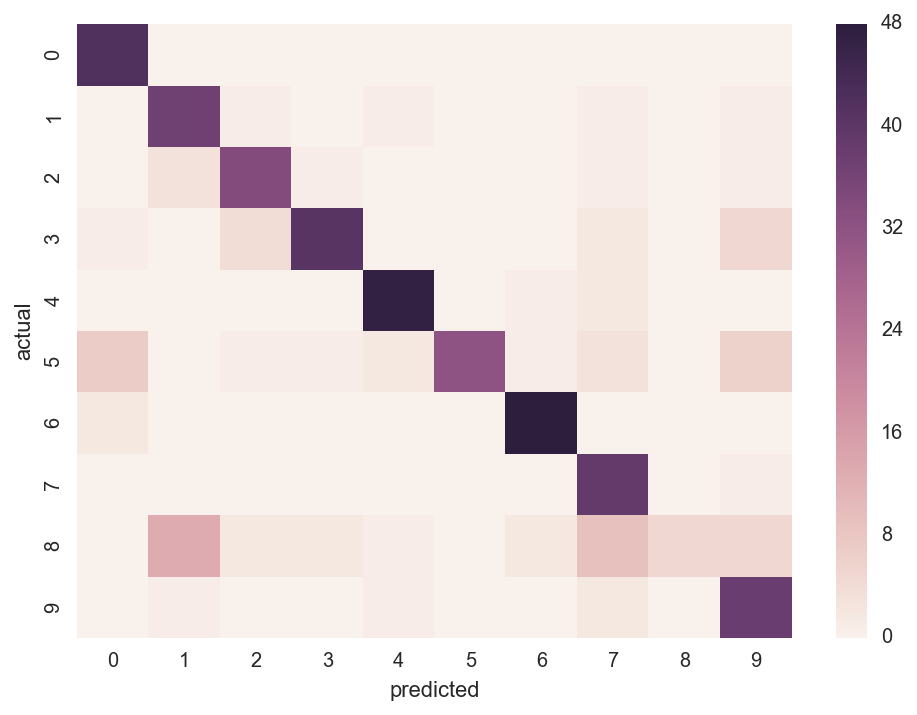

In [59]:
sns.heatmap(confusion_matrix(ytest, predict(Xtest)))
plt.xlabel('predicted')
plt.ylabel('actual');